Nama : Mazaya Nova Shabrina
Email : injeolminara@gmail.com
Domisili ; Purbalingga, Jawa Tengah

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from keras.layers import Dense, LSTM
import tensorflow as tf 

In [2]:
df = pd.read_csv('sample_data/Tesla.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

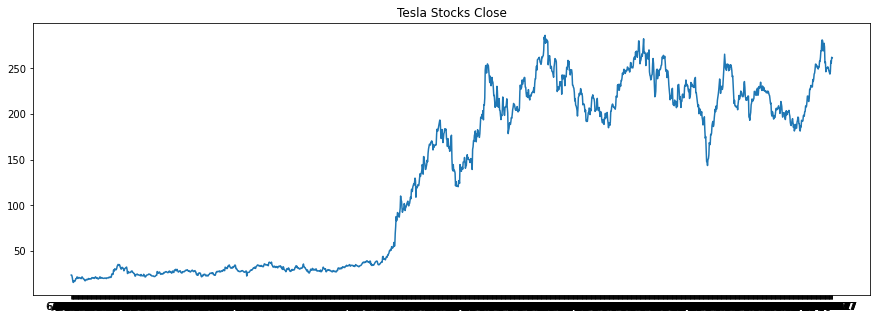

In [5]:
dates = df['Date'].values
close = df['Close'].values

plt.figure(figsize=(15,5))
plt.plot(dates, close)
plt.title('Tesla Stocks Close')
plt.show()


In [6]:
dates_train, dates_test, close_train, close_test = train_test_split(dates, close, test_size=0.2)


In [7]:
def windowed_dataset(series, window_size,batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)


In [8]:
train_set = windowed_dataset(close_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(close_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
])

In [9]:
Mae = (df['Close'].max() - df['Close'].min() * 10/100)

print(Mae)

284.460009


In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.4 and logs.get('val_mae')<2.4):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
      
      
callbacks = myCallback()



In [11]:
# Gunakan parameter learning rate dan momentum
# Loss Function HUBER(kasus time series)
# metric MAE

optimizer = tf.keras.optimizers.SGD(lr=1.000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data = val_set, epochs=100, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


13/13 [==============================] - 7s 228ms/step - loss: 131.8418 - mae: 132.3418 - val_loss: 132.6237 - val_mae: 133.1237
Epoch 2/100
13/13 [==============================] - 2s 117ms/step - loss: 131.8195 - mae: 132.3195 - val_loss: 132.5994 - val_mae: 133.0994
Epoch 3/100
13/13 [==============================] - 2s 115ms/step - loss: 131.7963 - mae: 132.2963 - val_loss: 132.5776 - val_mae: 133.0776
Epoch 4/100
13/13 [==============================] - 3s 206ms/step - loss: 131.7752 - mae: 132.2752 - val_loss: 132.5582 - val_mae: 133.0582
Epoch 5/100
13/13 [==============================] - 2s 141ms/step - loss: 131.7567 - mae: 132.2567 - val_loss: 132.5404 - val_mae: 133.0404
Epoch 6/100
13/13 [==============================] - 2s 114ms/step - loss: 131.7390 - mae: 132.2390 - val_loss: 132.5228 - val_mae: 133.0228
Epoch 7/100
13/13 [==============================] - 2s 115ms/step - loss: 131.7215 - mae: 132.2215 - val_loss: 132.5053 - val_mae: 133.0053
Epoch 8/100
13/13 [======

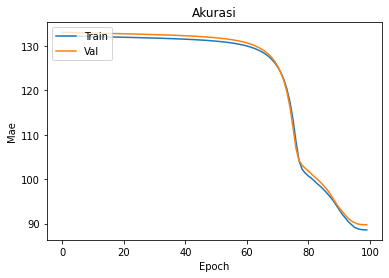

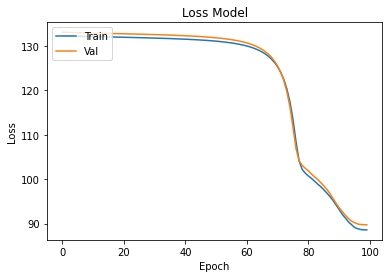

In [12]:
#accuracy 
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# plot loss 
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc = 'upper left')
plt.show()